In [1]:
import pandas as pd
import regex as re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import ahocorasick

import torch
from transformers import T5ForConditionalGeneration, AutoTokenizer, MT5ForConditionalGeneration, get_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
#from fairseq.optim.adafactor import Adafactor

from tqdm import tqdm
import matplotlib.pyplot as plt

from copy import deepcopy

In [2]:
# CONSTANTS:

SEP_TOKEN = '▁<extra_id_0>'
INPUT_PREFIX = ''

NUM_OF_SPLITS = 50

ATTACHMENT_TOKEN = '▁<extra_id_1>'
LABEL_PREFIX_TOKEN = ATTACHMENT_TOKEN

USED_MODEL_NAME = 'cointegrated/rut5-small'#'./coint_rut5small_finetune_fulltrain_novalid'#'./coint_rut5small_finetune_6171-8031'#'cointegrated/rut5-small'

SEQ_MAX_LENGTH = 150
ANSWER_MAX_LENGTH = 150
BATCH_SIZE = 4
EVAL_BATCH_SIZE = 64

ENABLE_LABEL_FIX = True

LOCAL_NUM_EPOCHS = 2

In [3]:
tokenizer = AutoTokenizer.from_pretrained (USED_MODEL_NAME)

device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')
#device = torch.device ('cpu')

model = MT5ForConditionalGeneration.from_pretrained (USED_MODEL_NAME)

model.to (device)
print (model.device)

num_epochs = 50
#training_steps = len (train_data ['input_ids']) // BATCH_SIZE * num_epochs
#warmup_steps = int (training_steps * 0.1)
#print (f'Suggested train steps: {training_steps}\n\t warmup steps: {int (training_steps * 0.05)} - {int (training_steps * 0.1)}')

#optimizer = AdamW (model.parameters (), lr = 1e-5)#, weight_decay = 0.05)
optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 5e-5, weight_decay = 0.01)
#optimizer = Adafactor (model.parameters (), lr = 3e-5, scale_parameter = False, relative_step = False, weight_decay = 0.02)
#scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = warmup_steps, num_training_steps = training_steps)

metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1_score': []}

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Enfi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


cuda:0


In [4]:

# FUNCTIONS:

def split_text (text, segments, delimiters = ['...', '.', '?!', '?', '!']):

    delimiters_pattern = '|'.join (map (re.escape, delimiters))
    
    paragraphs = re.split (f'(?<=\n[ ]*)', text)
    
    sentences_with_segments = []
    
    current_start_index = 0

    for paragraph in paragraphs:

        sentences = re.split (f'(?<=[{delimiters_pattern}] )(?=[A-ZА-ЯЁ])', paragraph)#.strip ())

        for sentence in sentences:

            start_index = current_start_index
            end_index = start_index + len (sentence)

            matched_segments = [
                text [start: end] for start, end in segments if start >= start_index and end <= end_index
            ]
            sentences_with_segments.append ((sentence, matched_segments))

            current_start_index = end_index
    
    return sentences_with_segments

def create_parallels (data_lst, labels_lst, with_dict = False):
    parallel_text = []
    parallel_label = []
    for i in range (len (data_lst)):
        text = data_lst [i]
        segments = labels_lst [i]
        splitted = split_text (text, segments)
        for sentence, terms in splitted:
            parallel_text.append (INPUT_PREFIX + sentence)

            constructed_label = ''
            if with_dict:
                constructed_label += LABEL_PREFIX_TOKEN
                for term in terms:
                    constructed_label += SEP_TOKEN + term.strip ()
            else:
                for term in terms:
                    constructed_label += term.strip () + SEP_TOKEN

            parallel_label.append (constructed_label)
    return parallel_text, parallel_label


def label_constructor (labels):
    res = []
    for label in labels:
        one_label = []
        for start, end, cls in label:
            one_label.append ([start, end])
        res.append (one_label)
    return res


def one_finder (text, phrases):

    if len (phrases) == 1 and '' in phrases:
        return []

    A = ahocorasick.Automaton ()
    
    for idx, phrase in enumerate (phrases):
        A.add_word (phrase, (idx, phrase))
    
    A.make_automaton ()
    
    found = []
    for end_index, (idx, phrase) in A.iter (text):
        start_index = end_index - len (phrase) + 1

        if start_index > 0 and text [start_index - 1].isalpha ():
            continue
        if end_index + 1 < len (text) and text [end_index + 1].isalpha ():
            continue

        found.append ((start_index, end_index + 1, phrase))
    
    return found

def make_attachment (text, dictionary_terms):
    found = one_finder (text, dictionary_terms)
    found_terms = [item [2] for item in found]
    res = text + ATTACHMENT_TOKEN
    for term in found_terms:
        res += SEP_TOKEN + term
    return res

def attach_dictionary_foundings (texts, dictionary_terms):
    res_texts = []
    for text in tqdm (texts):
        res_texts.append (make_attachment (text, dictionary_terms))
    return res_texts

def replace_padding (labels):
    for i in range (0, len (labels ['input_ids'])):
        labels ['input_ids'] [i] = torch.tensor ([labl if labl != 0 else - 100 for labl in labels ['input_ids'] [i]])

    return labels

class Seq2SeqDataset (Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__ (self, idx):
        return {
            'input_ids': self.encodings ['input_ids'] [idx],
            'attention_mask': self.encodings ['attention_mask'] [idx],
            'labels': self.labels ['input_ids'] [idx]
        }

    def __len__ (self):
        return len (self.encodings ['input_ids'])

def get_set (tensor, ground_truth = True, tokenizer = tokenizer):

    separator: str
    if SEP_TOKEN == '▁<extra_id_0>': separator = '<extra_id_0>'
    else: separator = SEP_TOKEN

    res: set

    if ground_truth:
        eos_idx = (tensor == 1).nonzero ()
        if eos_idx.numel () > 0:
            eos_idx = int (eos_idx [0] [0])
        else:
            eos_idx = len (tensor)
        seq = tensor [:eos_idx]
    
    else:
        seq = tensor [tensor != 0]
        seq = seq [seq != - 100]
        seq = seq [seq != 1]
    
    txt = tokenizer.decode (seq)
    res = set ([item.strip () for item in txt.split (separator)])

    if len (res) > 1:
        res -= set ([''])
    res -= set ([LABEL_PREFIX_TOKEN [1:]])
    if len (res) == 0: res |= set ([''])

    return res


def sanity_check (preds, labels, to_print = False):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):
        predicted_set = get_set (preds [i], ground_truth = False)
        true_set = get_set (labels [i])

        if to_print: print (f'True: {true_set}\nPred: {predicted_set}')

        tps_sum += len (true_set & predicted_set)  # Истинно положительные
        fps_sum += len (predicted_set - true_set)     # Ложноположительные
        fns_sum += len (true_set - predicted_set)     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [5]:
df = pd.read_json ('train_t1_v1.jsonl', lines = True)
df.drop (columns = ['id', 'keywords'], inplace = True)
print (df.head ())
print ()
df_2 = pd.read_json ('./test_data/test1_t12_full_v2.jsonl', lines = True)
df_2 = df_2 [['text', 'label']]
print (df_2.head ())
print ()

val_data_txt, test_data_txt, val_labels_txt, test_labels_txt = train_test_split (df_2 ['text'], df_2 ['label'], test_size = 0.5, random_state = 14)

train_data_lst = df ['text'].tolist ()
train_labels_lst = df ['label'].tolist ()
train_parallel_text, train_parallel_labels = create_parallels (train_data_lst, train_labels_lst)

val_data_lst = val_data_txt.tolist ()
val_labels_lst = label_constructor (val_labels_txt)
val_parallel_text, val_parallel_labels = create_parallels (val_data_lst, val_labels_lst)

test_data_lst = test_data_txt.tolist ()
test_labels_lst = label_constructor (test_labels_txt)
test_parallel_text, test_parallel_labels = create_parallels (test_data_lst, test_labels_lst)

all_train_terms = set ()
for line in train_parallel_labels:
    all_train_terms |= set (line.split (SEP_TOKEN))
all_train_terms -= set ([''])
all_train_terms -= set ([LABEL_PREFIX_TOKEN])
print (f'Уникальных терминов во всём тренировочном наборе: {len (all_train_terms)}.\n')

val_parallel_text_new = val_parallel_text#attach_dictionary_foundings (val_parallel_text, all_train_terms)
test_parallel_text_new = test_parallel_text#attach_dictionary_foundings (test_parallel_text, all_train_terms)

val_data = tokenizer (val_parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (val_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

test_data = tokenizer (test_parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
test_labels = tokenizer (test_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    
    replaced = replace_padding (val_labels)
    val_labels = replaced

    replaced = replace_padding (test_labels)
    test_labels = replaced

val_dataset = Seq2SeqDataset (val_data, val_labels)
test_dataset = Seq2SeqDataset (test_data, test_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)
test_loader = DataLoader (test_dataset, batch_size = EVAL_BATCH_SIZE)

                                                text  \
0  ABBYY Retrieval & Morphology Engine\nВ сообщен...   
1  Речевые формулы в диалоге\nПредложенная класси...   
2  Географические названия и полнотекстовые докум...   
3  Методы автоматического построения специализиро...   
4  Закономерности построения дискурсивной последо...   

                                               label  
0  [[0, 35], [6, 15], [18, 35], [29, 35], [69, 88...  
1  [[0, 15], [18, 25], [74, 99], [134, 140], [175...  
2  [[0, 23], [26, 50], [54, 68], [169, 190], [181...  
3  [[7, 63], [34, 63], [54, 63], [92, 128], [119,...  
4  [[26, 57], [62, 76], [251, 265], [266, 280], [...  

                                                text  \
0  АВТОМАТИЧЕСКИЙ АНАЛИЗ ТОНАЛЬНОСТИ ТЕКСТОВ НА О...   
1  InBASE: ТЕХНОЛОГИЯ ПОСТРОЕНИЯ ЕЯ-ИНТЕРФЕЙСОВ К...   
2  Выражение уважительности с помощью личных мест...   
3  ДА ЧЕРТ ЛИ В ДЕТАЛЯХ?.. МЕРА ДЛЯ ОЦЕНКИ СОВПАД...   
4  КОРПУСНАЯ ОЦЕНКА СОЧЕТАЕМОСТИ СЛОВ С ИСПОЛЬЗОВ...

(array([2.272e+03, 1.870e+03, 8.130e+02, 3.400e+02, 1.160e+02, 4.000e+01,
        1.600e+01, 5.000e+00, 1.000e+00, 1.000e+00]),
 array([  1.,  18.,  35.,  52.,  69.,  86., 103., 120., 137., 154., 171.]),
 <BarContainer object of 10 artists>)

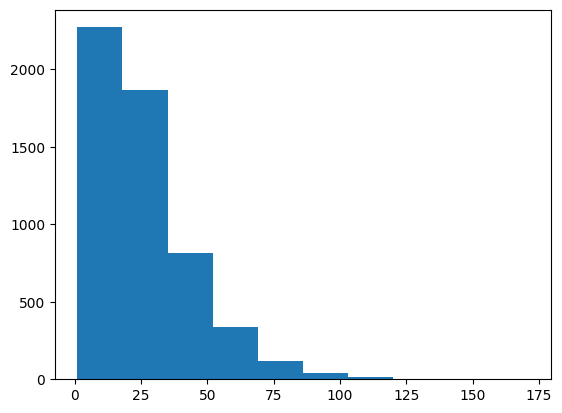

In [6]:

lengths = []

tknz = tokenizer (train_parallel_labels)
for tnsr in tknz ['input_ids']:
    lengths.append (len (tnsr))

tknz = tokenizer (val_parallel_labels)
for tnsr in tknz ['input_ids']:
    lengths.append (len (tnsr))

tknz = tokenizer (test_parallel_labels)
for tnsr in tknz ['input_ids']:
    lengths.append (len (tnsr))

plt.hist (lengths)

In [7]:
#checkpoint = torch.load ('./rut5small_7332-7420/checkpoint.pth')
#model.load_state_dict (checkpoint['model'])
#optimizer.load_state_dict (checkpoint['optimizer'])

In [8]:
num_passed_epochs = 0
view_at_loss = True

In [9]:
kf = KFold (n_splits = NUM_OF_SPLITS if NUM_OF_SPLITS > 1 else 2)

data = df ['text']
labels = df ['label']

test_indices = list (kf.split (data))
#test_indices.reverse ()


In [10]:
import numpy as np

if NUM_OF_SPLITS == 1:
    test_indices = [(0, np.concatenate ([test_indices [0] [1], test_indices [0] [0]]))]


In [11]:
prev_metric = 1000000 if view_at_loss else 0.5537
prev_model = deepcopy (model.state_dict ())
prev_optimizer = deepcopy (optimizer.state_dict ())

In [12]:

for SuperEpoch in range (0, 2):

    #inc_term_set = set ([''])
    avg_val_loss, prec, recl, f1sc = 0, 0, 0, 0
    for iteration, (train_index, test_index) in enumerate (kf.split (data)):
        X_curr = data [test_index]
        y_curr = labels [test_index]

        train_data_lst = X_curr.tolist ()
        train_labels_lst = y_curr.tolist ()
        parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)

        parallel_text_new = parallel_text#attach_dictionary_foundings (parallel_text, inc_term_set)

        train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
        train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')
        
        if ENABLE_LABEL_FIX:
            replaced = replace_padding (train_labels)
            train_labels = replaced

        train_dataset = Seq2SeqDataset (train_data, train_labels)
        train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)

        for epoch in range (LOCAL_NUM_EPOCHS):
            model.train ()  # Устанавливаем модель в режим обучения
            total_loss = 0
            
            for batch in tqdm (train_loader):
                
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                #outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
                outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
                loss = outputs.loss   ## DOUBLE CHECK if padding ...
                total_loss += loss.item ()

                loss.backward ()  # Обратное распространение
                optimizer.step ()  # Обновление параметров
                optimizer.zero_grad ()  # Обнуляем градиенты

                #scheduler.step ()  # Обновление learning rate
                torch.cuda.empty_cache ()
            

            avg_loss = total_loss / len (train_loader)

            metrics ['train_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, avg_loss))
            #print (f'Epoch {(epoch + 1) + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs} / {NUM_OF_SPLITS * LOCAL_NUM_EPOCHS + num_passed_epochs}, Loss: {avg_loss:.4f}')

        #for line in parallel_labels:
        #    inc_term_set |= set (line.split (SEP_TOKEN))
        #inc_term_set -= set ([''])
        #inc_term_set -= set ([LABEL_PREFIX_TOKEN])
        #print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')

            model.eval ()
            val_preds, val_labels = [], []
            total_val_loss = 0

            with torch.no_grad ():
                for batch in val_loader:
                    input_ids = batch ['input_ids'].to (model.device)
                    attention_mask = batch ['attention_mask'].to (model.device)
                    labels_fromdata = batch ['labels'].to (model.device)

                    outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length = SEQ_MAX_LENGTH)

                    total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()

                    val_preds.extend (outputs)
                    val_labels.extend (labels_fromdata)
                    torch.cuda.empty_cache ()

            avg_val_loss = total_val_loss / len (val_loader)

            prec, recl, f1sc = sanity_check (val_preds, val_labels)

            metrics ['val_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, avg_val_loss))
            metrics ['precision'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, prec))
            metrics ['recall'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, recl))
            metrics ['f1_score'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, f1sc))

            print (f'Epoch {(epoch + 1) + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs} / {NUM_OF_SPLITS * LOCAL_NUM_EPOCHS + num_passed_epochs}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
            
            torch.cuda.empty_cache ()
                
            if (view_at_loss and prev_metric > avg_val_loss) or (not view_at_loss and prev_metric < f1sc):
                prev_model = deepcopy (model.state_dict ())
                prev_optimizer = deepcopy (optimizer.state_dict ())
                prev_metric = avg_val_loss if view_at_loss else f1sc

        if (view_at_loss and prev_metric < avg_val_loss) or (not view_at_loss and prev_metric > f1sc):
            model.load_state_dict (prev_model)
            optimizer.load_state_dict (prev_optimizer)
            print (f'Fold: Откат к предыдущему {"val_loss" if view_at_loss else "f1_score"}: {avg_val_loss if view_at_loss else f1sc} -> {prev_metric}.')

    if (view_at_loss and prev_metric < avg_val_loss) or (not view_at_loss and prev_metric > f1sc):
        model.load_state_dict (prev_model)
        optimizer.load_state_dict (prev_optimizer)
        print (f' Run: Откат к предыдущему {"val_loss" if view_at_loss else "f1_score"}: {avg_val_loss if view_at_loss else f1sc} -> {prev_metric}.')

    num_passed_epochs += NUM_OF_SPLITS * LOCAL_NUM_EPOCHS
    



100%|██████████| 21/21 [00:02<00:00,  9.78it/s]


Epoch 1 / 100, Loss: 3.5946, Validation loss: 2.9137, 0.0016806722689075631 / 0.0004182350480970305 / 0.0006697923643670462


100%|██████████| 21/21 [00:02<00:00, 10.35it/s]


Epoch 2 / 100, Loss: 2.7233, Validation loss: 2.3829, 0.0033112582781456954 / 0.000836470096194061 / 0.001335559265442404


100%|██████████| 27/27 [00:02<00:00,  9.69it/s]


Epoch 3 / 100, Loss: 2.4828, Validation loss: 2.0455, 0.07019438444924406 / 0.027185278126306986 / 0.03919204100090443


100%|██████████| 27/27 [00:04<00:00,  6.41it/s]


Epoch 4 / 100, Loss: 2.1166, Validation loss: 1.8377, 0.1506849315068493 / 0.06900878293601004 / 0.0946643717728055


100%|██████████| 22/22 [00:03<00:00,  6.47it/s]


Epoch 5 / 100, Loss: 2.0276, Validation loss: 1.7496, 0.17770034843205576 / 0.08531994981179424 / 0.11528680418197233


100%|██████████| 22/22 [00:03<00:00,  6.41it/s]


Epoch 6 / 100, Loss: 1.8452, Validation loss: 1.6574, 0.22814321398834306 / 0.11459640317858637 / 0.15256124721603564


100%|██████████| 26/26 [00:04<00:00,  6.07it/s]


Epoch 7 / 100, Loss: 1.5700, Validation loss: 1.5342, 0.2818116462976276 / 0.16394813885403597 / 0.20729772607086197


100%|██████████| 26/26 [00:03<00:00,  6.51it/s]


Epoch 8 / 100, Loss: 1.4430, Validation loss: 1.3890, 0.35058823529411764 / 0.18695106649937265 / 0.24386252045826512


100%|██████████| 24/24 [00:03<00:00,  6.77it/s]


Epoch 9 / 100, Loss: 1.5272, Validation loss: 1.3302, 0.322884012539185 / 0.1723128398159766 / 0.22470684483228798


100%|██████████| 24/24 [00:03<00:00,  6.92it/s]


Epoch 10 / 100, Loss: 1.2562, Validation loss: 1.2255, 0.3564493758668516 / 0.21497281472187368 / 0.26819723454213407


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


Epoch 11 / 100, Loss: 1.3473, Validation loss: 1.1482, 0.37668161434977576 / 0.2107904642409034 / 0.27031375703942073


100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


Epoch 12 / 100, Loss: 1.2494, Validation loss: 1.0749, 0.4109014675052411 / 0.24592220828105396 / 0.3076923076923077


100%|██████████| 23/23 [00:03<00:00,  6.84it/s]


Epoch 13 / 100, Loss: 1.2005, Validation loss: 1.0458, 0.417312661498708 / 0.2701798410706817 / 0.328002030972328


100%|██████████| 23/23 [00:03<00:00,  6.72it/s]


Epoch 14 / 100, Loss: 1.1802, Validation loss: 1.0198, 0.43190416141235816 / 0.2864910079464659 / 0.34448076439527286


100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Epoch 15 / 100, Loss: 1.1287, Validation loss: 0.9998, 0.44397759103641454 / 0.26516102049351736 / 0.33202409007593614


100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Epoch 16 / 100, Loss: 1.0252, Validation loss: 0.9828, 0.45448227936066715 / 0.27352572145545795 / 0.3415143603133159


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch 17 / 100, Loss: 1.2042, Validation loss: 0.9728, 0.4528301886792453 / 0.3312421580928482 / 0.3826086956521739


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Epoch 18 / 100, Loss: 1.1712, Validation loss: 0.9562, 0.44501718213058417 / 0.32496863237139273 / 0.3756345177664974


100%|██████████| 30/30 [00:04<00:00,  6.92it/s]


Epoch 19 / 100, Loss: 1.1468, Validation loss: 0.9491, 0.46918604651162793 / 0.33751568381430364 / 0.39260520554609585


100%|██████████| 30/30 [00:04<00:00,  6.79it/s]


Epoch 20 / 100, Loss: 1.1027, Validation loss: 0.9437, 0.4569923932124049 / 0.32664157256378085 / 0.38097560975609757


100%|██████████| 26/26 [00:03<00:00,  6.71it/s]


Epoch 21 / 100, Loss: 1.1396, Validation loss: 0.9127, 0.4669718770438195 / 0.2986198243412798 / 0.3642857142857143


100%|██████████| 26/26 [00:03<00:00,  6.74it/s]


Epoch 22 / 100, Loss: 1.0623, Validation loss: 0.9076, 0.4651578320428827 / 0.32664157256378085 / 0.3837837837837838


100%|██████████| 31/31 [00:04<00:00,  6.50it/s]


Epoch 23 / 100, Loss: 1.0475, Validation loss: 0.8902, 0.4707865168539326 / 0.3504809703053116 / 0.40182210501078874


100%|██████████| 31/31 [00:04<00:00,  6.73it/s]


Epoch 24 / 100, Loss: 0.9403, Validation loss: 0.8872, 0.4734273318872017 / 0.36511919698870765 / 0.41227863046044866


100%|██████████| 20/20 [00:03<00:00,  6.44it/s]


Epoch 25 / 100, Loss: 0.8529, Validation loss: 0.9016, 0.4715665236051502 / 0.36762860727728985 / 0.41316098707403054


100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


Epoch 26 / 100, Loss: 0.7936, Validation loss: 0.8912, 0.4830917874396135 / 0.37641154328732745 / 0.42313117066290545
Fold: Откат к предыдущему val_loss: 0.8911616742610932 -> 0.8872189342975616.


100%|██████████| 18/18 [00:02<00:00,  6.77it/s]


Epoch 27 / 100, Loss: 0.9863, Validation loss: 0.8903, 0.4710017574692443 / 0.33626097867001253 / 0.3923865300146413


100%|██████████| 18/18 [00:02<00:00,  6.50it/s]


Epoch 28 / 100, Loss: 0.9182, Validation loss: 0.8941, 0.46114864864864863 / 0.342534504391468 / 0.3930885529157667
Fold: Откат к предыдущему val_loss: 0.8940719544887543 -> 0.8872189342975616.


100%|██████████| 17/17 [00:02<00:00,  6.80it/s]


Epoch 29 / 100, Loss: 0.9267, Validation loss: 0.8765, 0.4797525309336333 / 0.35675449602676707 / 0.40921084192852003


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 30 / 100, Loss: 0.9615, Validation loss: 0.8678, 0.4856972586412396 / 0.34086156419907987 / 0.4005898255099533


100%|██████████| 19/19 [00:02<00:00,  6.76it/s]


Epoch 31 / 100, Loss: 0.9140, Validation loss: 0.8562, 0.4922341696535245 / 0.3446256796319532 / 0.4054120541205412


100%|██████████| 19/19 [00:02<00:00,  6.85it/s]


Epoch 32 / 100, Loss: 0.8683, Validation loss: 0.8486, 0.48559670781893005 / 0.3454621497281472 / 0.4037145650048876


100%|██████████| 21/21 [00:03<00:00,  6.72it/s]


Epoch 33 / 100, Loss: 0.9328, Validation loss: 0.8340, 0.504882251579552 / 0.36762860727728985 / 0.425459825750242


100%|██████████| 21/21 [00:03<00:00,  6.55it/s]


Epoch 34 / 100, Loss: 0.9429, Validation loss: 0.8292, 0.49384098544232924 / 0.36888331242158096 / 0.4223126645918123


100%|██████████| 21/21 [00:03<00:00,  6.79it/s]


Epoch 35 / 100, Loss: 0.7428, Validation loss: 0.8316, 0.4802036199095023 / 0.35508155583437895 / 0.4082712190430392


100%|██████████| 21/21 [00:03<00:00,  6.63it/s]


Epoch 36 / 100, Loss: 0.7528, Validation loss: 0.8305, 0.49396267837541163 / 0.37641154328732745 / 0.42724899121765963
Fold: Откат к предыдущему val_loss: 0.8305371105670929 -> 0.829248970746994.


100%|██████████| 17/17 [00:02<00:00,  6.70it/s]


Epoch 37 / 100, Loss: 0.9465, Validation loss: 0.8217, 0.5022026431718062 / 0.38143036386449186 / 0.4335631091038745


100%|██████████| 17/17 [00:02<00:00,  6.40it/s]


Epoch 38 / 100, Loss: 0.8975, Validation loss: 0.8251, 0.5080779944289694 / 0.38143036386449186 / 0.4357381748686096
Fold: Откат к предыдущему val_loss: 0.8251121342182159 -> 0.8216917335987091.


100%|██████████| 18/18 [00:02<00:00,  6.82it/s]


Epoch 39 / 100, Loss: 0.9120, Validation loss: 0.8178, 0.4849315068493151 / 0.370138017565872 / 0.4198292220113852


100%|██████████| 18/18 [00:02<00:00,  6.60it/s]


Epoch 40 / 100, Loss: 0.8074, Validation loss: 0.8023, 0.5058896466212027 / 0.34127979924717694 / 0.4075924075924076


100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 41 / 100, Loss: 0.9317, Validation loss: 0.8093, 0.48507867607162236 / 0.3739021329987453 / 0.4222957014643363


100%|██████████| 16/16 [00:02<00:00,  6.64it/s]


Epoch 42 / 100, Loss: 0.8781, Validation loss: 0.8142, 0.4877384196185286 / 0.3743203680468423 / 0.4235683861807856
Fold: Откат к предыдущему val_loss: 0.8141887068748475 -> 0.8023014008998871.


100%|██████████| 19/19 [00:02<00:00,  6.64it/s]


Epoch 43 / 100, Loss: 0.8670, Validation loss: 0.8012, 0.4936998854524628 / 0.3605186114596403 / 0.4167270969301426


100%|██████████| 19/19 [00:02<00:00,  6.47it/s]


Epoch 44 / 100, Loss: 0.7840, Validation loss: 0.8104, 0.4904735982580294 / 0.3768297783354245 / 0.42620624408703883
Fold: Откат к предыдущему val_loss: 0.8103892624378204 -> 0.8012086749076843.


100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 45 / 100, Loss: 0.8512, Validation loss: 0.8158, 0.4844981607987388 / 0.3856127143454621 / 0.42943642291569634


100%|██████████| 16/16 [00:02<00:00,  6.56it/s]


Epoch 46 / 100, Loss: 0.7555, Validation loss: 0.8062, 0.4926590538336052 / 0.37892095357590966 / 0.42836879432624114
Fold: Откат к предыдущему val_loss: 0.8062418222427368 -> 0.8012086749076843.


100%|██████████| 18/18 [00:02<00:00,  6.62it/s]


Epoch 47 / 100, Loss: 0.9087, Validation loss: 0.8037, 0.4861878453038674 / 0.36804684232538687 / 0.4189478695548679


100%|██████████| 18/18 [00:02<00:00,  6.83it/s]


Epoch 48 / 100, Loss: 0.9115, Validation loss: 0.8152, 0.4813233724653148 / 0.37724801338352154 / 0.42297772567409136
Fold: Откат к предыдущему val_loss: 0.8151899158954621 -> 0.8012086749076843.


100%|██████████| 17/17 [00:02<00:00,  6.72it/s]


Epoch 49 / 100, Loss: 0.8399, Validation loss: 0.8101, 0.48925043579314353 / 0.35215391049769973 / 0.4095330739299611


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 50 / 100, Loss: 0.7481, Validation loss: 0.8254, 0.48722316865417375 / 0.3588456712672522 / 0.4132947976878612
Fold: Откат к предыдущему val_loss: 0.8253876626491546 -> 0.8012086749076843.


100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 51 / 100, Loss: 0.9377, Validation loss: 0.8199, 0.4827195467422096 / 0.35633626097867 / 0.41000962463907603


100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 52 / 100, Loss: 0.8270, Validation loss: 0.8295, 0.48724179829890646 / 0.3354245085738185 / 0.3973247460985881
Fold: Откат к предыдущему val_loss: 0.8295019149780274 -> 0.8012086749076843.


100%|██████████| 15/15 [00:02<00:00,  6.58it/s]


Epoch 53 / 100, Loss: 0.8500, Validation loss: 0.8094, 0.4920022062879206 / 0.3730656629025512 / 0.4243577545195052


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


Epoch 54 / 100, Loss: 0.7534, Validation loss: 0.7995, 0.514302393461763 / 0.3684650773734839 / 0.4293372319688109


100%|██████████| 16/16 [00:02<00:00,  6.54it/s]


Epoch 55 / 100, Loss: 0.8199, Validation loss: 0.8122, 0.4979057591623037 / 0.397741530740276 / 0.44222273889793073


100%|██████████| 16/16 [00:02<00:00,  6.52it/s]


Epoch 56 / 100, Loss: 0.7785, Validation loss: 0.8363, 0.4754335260115607 / 0.4127979924717691 / 0.4419073203492277
Fold: Откат к предыдущему val_loss: 0.8362794041633606 -> 0.7995035946369171.


100%|██████████| 17/17 [00:02<00:00,  6.50it/s]


Epoch 57 / 100, Loss: 0.8613, Validation loss: 0.8129, 0.4943298969072165 / 0.4010874111250523 / 0.4428538443777419


100%|██████████| 17/17 [00:02<00:00,  6.68it/s]


Epoch 58 / 100, Loss: 0.8055, Validation loss: 0.8320, 0.4735051045211473 / 0.40736093684650776 / 0.43794964028776984
Fold: Откат к предыдущему val_loss: 0.832005912065506 -> 0.7995035946369171.


100%|██████████| 19/19 [00:01<00:00, 10.58it/s]


Epoch 59 / 100, Loss: 1.0429, Validation loss: 0.7703, 0.5090379008746355 / 0.36511919698870765 / 0.4252313687286897


100%|██████████| 19/19 [00:01<00:00, 10.27it/s]


Epoch 60 / 100, Loss: 0.8562, Validation loss: 0.7710, 0.4911012235817575 / 0.36930154746967797 / 0.4215803294342325
Fold: Откат к предыдущему val_loss: 0.7709646582603454 -> 0.7703247547149659.


100%|██████████| 16/16 [00:01<00:00, 10.82it/s]


Epoch 61 / 100, Loss: 0.9686, Validation loss: 0.7728, 0.49069003285870755 / 0.37473860309493934 / 0.4249466445340289


100%|██████████| 16/16 [00:01<00:00, 10.53it/s]


Epoch 62 / 100, Loss: 0.8587, Validation loss: 0.7681, 0.5010764262648009 / 0.38937682977833543 / 0.4382207578253707


100%|██████████| 17/17 [00:01<00:00, 10.47it/s]


Epoch 63 / 100, Loss: 0.8398, Validation loss: 0.7817, 0.4835 / 0.40443329150982854 / 0.4404463675700296


100%|██████████| 17/17 [00:01<00:00, 10.23it/s]


Epoch 64 / 100, Loss: 0.7744, Validation loss: 0.7692, 0.48443775100401604 / 0.40359682141363445 / 0.4403376682637463
Fold: Откат к предыдущему val_loss: 0.76917005777359 -> 0.768121886253357.


100%|██████████| 17/17 [00:02<00:00,  6.80it/s]


Epoch 65 / 100, Loss: 0.9626, Validation loss: 0.7494, 0.511614730878187 / 0.37766624843161856 / 0.43455245428296435


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 66 / 100, Loss: 0.8572, Validation loss: 0.7566, 0.5164319248826291 / 0.36804684232538687 / 0.4297924297924298
Fold: Откат к предыдущему val_loss: 0.7565606951713562 -> 0.749386864900589.


100%|██████████| 18/18 [00:02<00:00,  6.80it/s]


Epoch 67 / 100, Loss: 0.9341, Validation loss: 0.7583, 0.510545905707196 / 0.3442074445838561 / 0.4111916062952785


100%|██████████| 18/18 [00:02<00:00,  6.37it/s]


Epoch 68 / 100, Loss: 0.8796, Validation loss: 0.7609, 0.5043525571273123 / 0.3877038895859473 / 0.4384015133601324
Fold: Откат к предыдущему val_loss: 0.760865181684494 -> 0.749386864900589.


100%|██████████| 15/15 [00:02<00:00,  6.82it/s]


Epoch 69 / 100, Loss: 0.9050, Validation loss: 0.7641, 0.4899257688229056 / 0.3864491844416562 / 0.4320785597381342


100%|██████████| 15/15 [00:02<00:00,  6.70it/s]


Epoch 70 / 100, Loss: 0.8773, Validation loss: 0.7783, 0.47935891209324916 / 0.4127979924717691 / 0.44359550561797756
Fold: Откат к предыдущему val_loss: 0.7783445835113525 -> 0.749386864900589.


100%|██████████| 16/16 [00:02<00:00,  6.44it/s]


Epoch 71 / 100, Loss: 0.9202, Validation loss: 0.7630, 0.4928076718167288 / 0.38686741948975323 / 0.4334582942830365


100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 72 / 100, Loss: 0.8674, Validation loss: 0.7687, 0.49511930585683295 / 0.3818485989125889 / 0.43116883116883115
Fold: Откат к предыдущему val_loss: 0.7686693370342255 -> 0.749386864900589.


100%|██████████| 18/18 [00:02<00:00,  6.82it/s]


Epoch 73 / 100, Loss: 0.8624, Validation loss: 0.7485, 0.5160599571734475 / 0.40317858636553744 / 0.45268842451279645


100%|██████████| 18/18 [00:02<00:00,  6.71it/s]


Epoch 74 / 100, Loss: 0.8749, Validation loss: 0.7639, 0.5039619651347068 / 0.3989962358845671 / 0.44537815126050423
Fold: Откат к предыдущему val_loss: 0.7638795793056488 -> 0.7485404551029206.


100%|██████████| 15/15 [00:02<00:00,  6.64it/s]


Epoch 75 / 100, Loss: 0.9606, Validation loss: 0.7811, 0.4838709677419355 / 0.4077791718946048 / 0.44257830231502493


100%|██████████| 15/15 [00:02<00:00,  6.75it/s]


Epoch 76 / 100, Loss: 0.9056, Validation loss: 0.7768, 0.4812286689419795 / 0.4127979924717691 / 0.4443944169293111
Fold: Откат к предыдущему val_loss: 0.7768198728561402 -> 0.7485404551029206.


100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


Epoch 77 / 100, Loss: 0.8945, Validation loss: 0.7508, 0.5025906735751295 / 0.40568799665411964 / 0.44897014579958344


100%|██████████| 20/20 [00:02<00:00,  6.81it/s]


Epoch 78 / 100, Loss: 0.8425, Validation loss: 0.7645, 0.5011742602160639 / 0.4462567963195316 / 0.4721238938053098
Fold: Откат к предыдущему val_loss: 0.7644576609134675 -> 0.7485404551029206.


100%|██████████| 26/26 [00:03<00:00,  6.90it/s]


Epoch 79 / 100, Loss: 0.8498, Validation loss: 0.7417, 0.5350877192982456 / 0.38268506900878296 / 0.44623262618873444


100%|██████████| 26/26 [00:04<00:00,  6.34it/s]


Epoch 80 / 100, Loss: 0.7965, Validation loss: 0.7418, 0.5357929515418502 / 0.4069427017984107 / 0.4625623960066556
Fold: Откат к предыдущему val_loss: 0.7417691230773926 -> 0.7417141556739807.


100%|██████████| 24/24 [00:03<00:00,  6.44it/s]


Epoch 81 / 100, Loss: 0.8597, Validation loss: 0.7245, 0.5338305807139052 / 0.4190715181932246 / 0.4695407685098407


100%|██████████| 24/24 [00:03<00:00,  6.35it/s]


Epoch 82 / 100, Loss: 0.8526, Validation loss: 0.7078, 0.5424018212862834 / 0.3985780008364701 / 0.4594985535197686


100%|██████████| 28/28 [00:04<00:00,  6.87it/s]


Epoch 83 / 100, Loss: 0.7936, Validation loss: 0.6999, 0.5448933782267116 / 0.40610623170221666 / 0.4653726335969327


100%|██████████| 28/28 [00:04<00:00,  6.85it/s]


Epoch 84 / 100, Loss: 0.8165, Validation loss: 0.7206, 0.5251450676982592 / 0.45420326223337515 / 0.48710473200269117
Fold: Откат к предыдущему val_loss: 0.7205789387226105 -> 0.699930727481842.


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Epoch 85 / 100, Loss: 0.9341, Validation loss: 0.7085, 0.5324144971924452 / 0.4362191551652028 / 0.47954022988505746


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Epoch 86 / 100, Loss: 0.8282, Validation loss: 0.7074, 0.5434447300771208 / 0.44207444583856126 / 0.48754612546125464
Fold: Откат к предыдущему val_loss: 0.7074278831481934 -> 0.699930727481842.


100%|██████████| 27/27 [00:04<00:00,  6.41it/s]


Epoch 87 / 100, Loss: 0.8411, Validation loss: 0.7108, 0.5263718700053277 / 0.41321622751986614 / 0.4629803186504218


100%|██████████| 27/27 [00:04<00:00,  6.53it/s]


Epoch 88 / 100, Loss: 0.8576, Validation loss: 0.6977, 0.5539526832083093 / 0.4015056461731493 / 0.46556741028128035


100%|██████████| 28/28 [00:04<00:00,  6.37it/s]


Epoch 89 / 100, Loss: 0.8128, Validation loss: 0.7005, 0.5578651685393259 / 0.41530740276035133 / 0.47614480939822584


100%|██████████| 28/28 [00:04<00:00,  6.68it/s]


Epoch 90 / 100, Loss: 0.7484, Validation loss: 0.7302, 0.5534351145038168 / 0.424508573818486 / 0.4804733727810651
Fold: Откат к предыдущему val_loss: 0.7301835119724274 -> 0.6976840019226074.


100%|██████████| 30/30 [00:04<00:00,  6.48it/s]


Epoch 91 / 100, Loss: 0.8563, Validation loss: 0.6982, 0.530004800768123 / 0.4617314930991217 / 0.49351810460438084


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 92 / 100, Loss: 0.7644, Validation loss: 0.6996, 0.5208140610545791 / 0.4709326641572564 / 0.49461893257193057
Fold: Откат к предыдущему val_loss: 0.6996346890926362 -> 0.6976840019226074.


100%|██████████| 27/27 [00:03<00:00,  6.76it/s]


Epoch 93 / 100, Loss: 0.8715, Validation loss: 0.7125, 0.5281173594132029 / 0.451693851944793 / 0.48692515779981965


100%|██████████| 27/27 [00:04<00:00,  6.73it/s]


Epoch 94 / 100, Loss: 0.7817, Validation loss: 0.7114, 0.5350025549310169 / 0.437892095357591 / 0.4816007359705612
Fold: Откат к предыдущему val_loss: 0.7113580644130707 -> 0.6976840019226074.


100%|██████████| 24/24 [00:03<00:00,  6.42it/s]


Epoch 95 / 100, Loss: 0.8369, Validation loss: 0.7145, 0.5292694726656991 / 0.4575491426181514 / 0.4908030506953791


100%|██████████| 24/24 [00:03<00:00,  6.44it/s]


Epoch 96 / 100, Loss: 0.7739, Validation loss: 0.7167, 0.5409252669039146 / 0.4450020911752405 / 0.4882973841211565
Fold: Откат к предыдущему val_loss: 0.716748708486557 -> 0.6976840019226074.


100%|██████████| 27/27 [00:04<00:00,  6.70it/s]


Epoch 97 / 100, Loss: 0.8445, Validation loss: 0.7130, 0.5289684408855393 / 0.4696779590129653 / 0.4975631369073992


100%|██████████| 27/27 [00:04<00:00,  6.67it/s]


Epoch 98 / 100, Loss: 0.7688, Validation loss: 0.7197, 0.5212620027434842 / 0.4767879548306148 / 0.49803407601572736
Fold: Откат к предыдущему val_loss: 0.7197128474712372 -> 0.6976840019226074.


100%|██████████| 20/20 [00:03<00:00,  6.64it/s]


Epoch 99 / 100, Loss: 0.9493, Validation loss: 0.7207, 0.5188501413760603 / 0.4604767879548306 / 0.4879237757589187


100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


Epoch 100 / 100, Loss: 0.8909, Validation loss: 0.7036, 0.5139826422372228 / 0.44583856127143456 / 0.47749160134378504
Fold: Откат к предыдущему val_loss: 0.7035546779632569 -> 0.6976840019226074.
 Run: Откат к предыдущему val_loss: 0.7035546779632569 -> 0.6976840019226074.


100%|██████████| 21/21 [00:03<00:00,  6.39it/s]


Epoch 101 / 200, Loss: 0.8176, Validation loss: 0.7107, 0.5050551470588235 / 0.45964031785863657 / 0.4812787387781914


100%|██████████| 21/21 [00:03<00:00,  6.61it/s]


Epoch 102 / 200, Loss: 0.7528, Validation loss: 0.7183, 0.4967860422405877 / 0.45253032204098703 / 0.47362661413876117
Fold: Откат к предыдущему val_loss: 0.7183233559131622 -> 0.6976840019226074.


100%|██████████| 27/27 [00:04<00:00,  6.73it/s]


Epoch 103 / 200, Loss: 0.7503, Validation loss: 0.7010, 0.5301662707838479 / 0.46675031367628605 / 0.49644128113879


100%|██████████| 27/27 [00:03<00:00,  6.77it/s]


Epoch 104 / 200, Loss: 0.6725, Validation loss: 0.7073, 0.5298165137614679 / 0.48306148055207027 / 0.5053598774885145
Fold: Откат к предыдущему val_loss: 0.7072755813598632 -> 0.6976840019226074.


100%|██████████| 22/22 [00:03<00:00,  6.45it/s]


Epoch 105 / 200, Loss: 0.8259, Validation loss: 0.7028, 0.5480020757654385 / 0.44165621079046424 / 0.4891153311718388


100%|██████████| 22/22 [00:03<00:00,  6.66it/s]


Epoch 106 / 200, Loss: 0.7830, Validation loss: 0.6938, 0.5531686358754028 / 0.43078209953994145 / 0.4843639783682106


100%|██████████| 26/26 [00:03<00:00,  6.62it/s]


Epoch 107 / 200, Loss: 0.7550, Validation loss: 0.7075, 0.5369877594465141 / 0.4219991635299038 / 0.4725995316159251


100%|██████████| 26/26 [00:03<00:00,  6.65it/s]


Epoch 108 / 200, Loss: 0.6779, Validation loss: 0.7128, 0.5325013000520021 / 0.42827268925135925 / 0.47473342605470564
Fold: Откат к предыдущему val_loss: 0.7127871751785279 -> 0.6937889873981475.


100%|██████████| 24/24 [00:03<00:00,  6.37it/s]


Epoch 109 / 200, Loss: 0.7471, Validation loss: 0.7142, 0.5273579989577906 / 0.4232538686741949 / 0.4696055684454757


100%|██████████| 24/24 [00:03<00:00,  6.73it/s]


Epoch 110 / 200, Loss: 0.6818, Validation loss: 0.7141, 0.5284510010537408 / 0.41948975324132165 / 0.46770809046397765
Fold: Откат к предыдущему val_loss: 0.7141381621360778 -> 0.6937889873981475.


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Epoch 111 / 200, Loss: 0.7727, Validation loss: 0.7002, 0.56243272335845 / 0.4370556252613969 / 0.4918804424570487


100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Epoch 112 / 200, Loss: 0.6896, Validation loss: 0.7267, 0.5359202936549554 / 0.4274362191551652 / 0.4755700325732899
Fold: Откат к предыдущему val_loss: 0.7267200708389282 -> 0.6937889873981475.


100%|██████████| 23/23 [00:03<00:00,  6.65it/s]


Epoch 113 / 200, Loss: 0.7369, Validation loss: 0.6921, 0.5484515484515484 / 0.4592220828105395 / 0.49988618256316864


100%|██████████| 23/23 [00:03<00:00,  6.57it/s]


Epoch 114 / 200, Loss: 0.6981, Validation loss: 0.6964, 0.5351299326275265 / 0.46507737348389794 / 0.49765048109196686
Fold: Откат к предыдущему val_loss: 0.6964427947998046 -> 0.6920608818531037.


100%|██████████| 27/27 [00:03<00:00,  6.76it/s]


Epoch 115 / 200, Loss: 0.7858, Validation loss: 0.6936, 0.5657894736842105 / 0.4316185696361355 / 0.48967971530249105


100%|██████████| 27/27 [00:03<00:00,  6.77it/s]


Epoch 116 / 200, Loss: 0.7003, Validation loss: 0.6977, 0.5546492659053833 / 0.42659974905897113 / 0.48226950354609927
Fold: Откат к предыдущему val_loss: 0.6977117419242859 -> 0.6920608818531037.


100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Epoch 117 / 200, Loss: 0.8250, Validation loss: 0.7036, 0.517208413001912 / 0.45253032204098703 / 0.4827124693285746


100%|██████████| 25/25 [00:02<00:00, 10.59it/s]


Epoch 118 / 200, Loss: 0.7857, Validation loss: 0.7128, 0.5083025830258303 / 0.4608950230029277 / 0.4834393507348103
Fold: Откат к предыдущему val_loss: 0.7127554953098297 -> 0.6920608818531037.


100%|██████████| 30/30 [00:02<00:00, 10.62it/s]


Epoch 119 / 200, Loss: 0.8078, Validation loss: 0.6972, 0.5462354724608388 / 0.45211208699289 / 0.4947368421052632


100%|██████████| 30/30 [00:02<00:00, 10.22it/s]


Epoch 120 / 200, Loss: 0.7549, Validation loss: 0.7050, 0.5297619047619048 / 0.4466750313676286 / 0.4846834581347856
Fold: Откат к предыдущему val_loss: 0.7049631834030151 -> 0.6920608818531037.


100%|██████████| 26/26 [00:02<00:00, 10.42it/s]


Epoch 121 / 200, Loss: 0.8441, Validation loss: 0.7064, 0.5382653061224489 / 0.4412379757423672 / 0.48494598942771777


100%|██████████| 26/26 [00:02<00:00, 10.12it/s]


Epoch 122 / 200, Loss: 0.7399, Validation loss: 0.7022, 0.564072557050907 / 0.40317858636553744 / 0.4702439024390244
Fold: Откат к предыдущему val_loss: 0.7021913826465607 -> 0.6920608818531037.


100%|██████████| 31/31 [00:02<00:00, 10.46it/s]


Epoch 123 / 200, Loss: 0.7418, Validation loss: 0.7032, 0.5156826568265682 / 0.46758678377248014 / 0.4904584338670761


100%|██████████| 31/31 [00:02<00:00, 10.71it/s]


Epoch 124 / 200, Loss: 0.8093, Validation loss: 0.6908, 0.5255347010039284 / 0.5035549979088247 / 0.5143101238786844


100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Epoch 125 / 200, Loss: 0.7277, Validation loss: 0.7092, 0.5267245317496574 / 0.4822250104558762 / 0.5034934497816593


100%|██████████| 20/20 [00:02<00:00,  6.80it/s]


Epoch 126 / 200, Loss: 0.7182, Validation loss: 0.7278, 0.519222271321255 / 0.49142618151401085 / 0.5049419853889127
Fold: Откат к предыдущему val_loss: 0.7278279066085815 -> 0.69077849984169.


100%|██████████| 18/18 [00:02<00:00,  6.56it/s]


Epoch 127 / 200, Loss: 0.7673, Validation loss: 0.6989, 0.5247389922832502 / 0.4834797156001673 / 0.5032651284283849


100%|██████████| 18/18 [00:02<00:00,  6.68it/s]


Epoch 128 / 200, Loss: 0.7136, Validation loss: 0.6954, 0.5471389645776567 / 0.41990798828941867 / 0.47515380974917176
Fold: Откат к предыдущему val_loss: 0.6954486310482025 -> 0.69077849984169.


100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


Epoch 129 / 200, Loss: 0.7560, Validation loss: 0.6822, 0.5495951417004049 / 0.45420326223337515 / 0.49736661323563097


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 130 / 200, Loss: 0.7060, Validation loss: 0.6959, 0.5177111716621253 / 0.4767879548306148 / 0.4964075767472241
Fold: Откат к предыдущему val_loss: 0.6958866596221924 -> 0.6822079002857209.


100%|██████████| 19/19 [00:02<00:00,  6.93it/s]


Epoch 131 / 200, Loss: 0.7391, Validation loss: 0.6799, 0.5426470588235294 / 0.4629861982434128 / 0.49966147596479343


100%|██████████| 19/19 [00:02<00:00,  6.39it/s]


Epoch 132 / 200, Loss: 0.7296, Validation loss: 0.6735, 0.5590749120160885 / 0.46507737348389794 / 0.5077625570776255


100%|██████████| 21/21 [00:03<00:00,  6.75it/s]


Epoch 133 / 200, Loss: 0.7384, Validation loss: 0.6615, 0.5809217577706324 / 0.4533667921371811 / 0.5092788348602302


100%|██████████| 21/21 [00:03<00:00,  6.75it/s]


Epoch 134 / 200, Loss: 0.7146, Validation loss: 0.6649, 0.5643614336193842 / 0.46758678377248014 / 0.5114364135407137
Fold: Откат к предыдущему val_loss: 0.6649348258972168 -> 0.6615444660186768.


100%|██████████| 21/21 [00:03<00:00,  6.91it/s]


Epoch 135 / 200, Loss: 0.6702, Validation loss: 0.6666, 0.5865892291446674 / 0.4646591384358009 / 0.5185530921820304


100%|██████████| 21/21 [00:03<00:00,  6.83it/s]


Epoch 136 / 200, Loss: 0.6526, Validation loss: 0.6690, 0.5609293504030346 / 0.49477206189878714 / 0.5257777777777778
Fold: Откат к предыдущему val_loss: 0.6689638495445251 -> 0.6615444660186768.


100%|██████████| 17/17 [00:02<00:00,  6.80it/s]


Epoch 137 / 200, Loss: 0.7104, Validation loss: 0.6718, 0.566147859922179 / 0.4868255959849435 / 0.5234989880818529


100%|██████████| 17/17 [00:02<00:00,  6.80it/s]


Epoch 138 / 200, Loss: 0.6936, Validation loss: 0.6810, 0.5635411708710139 / 0.49519029694688416 / 0.5271593944790739
Fold: Откат к предыдущему val_loss: 0.6809949815273285 -> 0.6615444660186768.


100%|██████████| 18/18 [00:02<00:00,  6.71it/s]


Epoch 139 / 200, Loss: 0.6679, Validation loss: 0.6768, 0.5586343394359228 / 0.4721873693015475 / 0.5117860380779692


100%|██████████| 18/18 [00:02<00:00,  6.81it/s]


Epoch 140 / 200, Loss: 0.6682, Validation loss: 0.6811, 0.5385668644454586 / 0.49351735675449604 / 0.515058926233086
Fold: Откат к предыдущему val_loss: 0.6811193943023681 -> 0.6615444660186768.


100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 141 / 200, Loss: 0.7653, Validation loss: 0.6670, 0.5568238213399503 / 0.46925972396486826 / 0.5093054925102134


100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 142 / 200, Loss: 0.6991, Validation loss: 0.6856, 0.5462616822429907 / 0.4889167712254287 / 0.5160008828073273
Fold: Откат к предыдущему val_loss: 0.6855522215366363 -> 0.6615444660186768.


100%|██████████| 19/19 [00:02<00:00,  6.83it/s]


Epoch 143 / 200, Loss: 0.7183, Validation loss: 0.6758, 0.563441905687895 / 0.4847344207444584 / 0.5211330935251799


100%|██████████| 19/19 [00:03<00:00,  6.32it/s]


Epoch 144 / 200, Loss: 0.6252, Validation loss: 0.6848, 0.5447728275253639 / 0.5165202843998327 / 0.5302705023615285
Fold: Откат к предыдущему val_loss: 0.6847832024097442 -> 0.6615444660186768.


100%|██████████| 16/16 [00:02<00:00,  6.53it/s]


Epoch 145 / 200, Loss: 0.7199, Validation loss: 0.6658, 0.5620253164556962 / 0.4642409033877039 / 0.5084745762711865


100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 146 / 200, Loss: 0.6940, Validation loss: 0.6830, 0.5549160671462829 / 0.48389795064826435 / 0.5169794459338695
Fold: Откат к предыдущему val_loss: 0.6829703211784363 -> 0.6615444660186768.


100%|██████████| 18/18 [00:01<00:00, 10.23it/s]


Epoch 147 / 200, Loss: 0.7578, Validation loss: 0.6850, 0.5355364418288818 / 0.49477206189878714 / 0.5143478260869566


100%|██████████| 18/18 [00:01<00:00, 10.07it/s]


Epoch 148 / 200, Loss: 0.6858, Validation loss: 0.6891, 0.5202156334231806 / 0.48431618569636137 / 0.5016244314489928
Fold: Откат к предыдущему val_loss: 0.689102154970169 -> 0.6615444660186768.


100%|██████████| 17/17 [00:01<00:00, 10.16it/s]


Epoch 149 / 200, Loss: 0.7659, Validation loss: 0.6694, 0.5684430512016719 / 0.45503973232956924 / 0.505458768873403


100%|██████████| 17/17 [00:01<00:00, 10.70it/s]


Epoch 150 / 200, Loss: 0.7321, Validation loss: 0.6752, 0.5515929624346172 / 0.4851526557925554 / 0.516243880729862
Fold: Откат к предыдущему val_loss: 0.6752030789852143 -> 0.6615444660186768.


100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 151 / 200, Loss: 0.7557, Validation loss: 0.6732, 0.5653333333333334 / 0.44332915098285236 / 0.496952648851383


100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


Epoch 152 / 200, Loss: 0.6830, Validation loss: 0.6863, 0.5488301119023398 / 0.45127561689669593 / 0.49529492770254757
Fold: Откат к предыдущему val_loss: 0.6863084375858307 -> 0.6615444660186768.


100%|██████████| 15/15 [00:02<00:00,  7.03it/s]


Epoch 153 / 200, Loss: 0.6432, Validation loss: 0.6695, 0.5727911646586346 / 0.47720618987871183 / 0.5206479580196212


100%|██████████| 15/15 [00:02<00:00,  7.06it/s]


Epoch 154 / 200, Loss: 0.6565, Validation loss: 0.6733, 0.5724398301085417 / 0.507319113341698 / 0.5379157427937915
Fold: Откат к предыдущему val_loss: 0.6733365952968597 -> 0.6615444660186768.


100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 155 / 200, Loss: 0.7962, Validation loss: 0.6758, 0.5645481628599801 / 0.4755332496863237 / 0.5162315550510783


100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 156 / 200, Loss: 0.7638, Validation loss: 0.6938, 0.5407442298634009 / 0.48013383521539105 / 0.5086397873283119
Fold: Откат к предыдущему val_loss: 0.6937986433506012 -> 0.6615444660186768.


100%|██████████| 17/17 [00:02<00:00,  6.78it/s]


Epoch 157 / 200, Loss: 0.8036, Validation loss: 0.6872, 0.5328338475099162 / 0.5056461731493099 / 0.5188841201716738


100%|██████████| 17/17 [00:02<00:00,  7.02it/s]


Epoch 158 / 200, Loss: 0.7378, Validation loss: 0.6904, 0.5149957155098543 / 0.5027185278126307 / 0.5087830687830688
Fold: Откат к предыдущему val_loss: 0.6904128551483154 -> 0.6615444660186768.


100%|██████████| 19/19 [00:01<00:00, 10.93it/s]


Epoch 159 / 200, Loss: 0.7272, Validation loss: 0.6950, 0.5251700680272109 / 0.48431618569636137 / 0.5039164490861618


100%|██████████| 19/19 [00:01<00:00, 10.39it/s]


Epoch 160 / 200, Loss: 0.6396, Validation loss: 0.6872, 0.5417661097852029 / 0.4746967795901297 / 0.5060187249219795
Fold: Откат к предыдущему val_loss: 0.6872469425201416 -> 0.6615444660186768.


100%|██████████| 16/16 [00:01<00:00, 10.13it/s]


Epoch 161 / 200, Loss: 0.7978, Validation loss: 0.6635, 0.5712841253791708 / 0.4726056043496445 / 0.5172808422980087


100%|██████████| 16/16 [00:01<00:00, 10.43it/s]


Epoch 162 / 200, Loss: 0.7500, Validation loss: 0.6732, 0.5505406676069582 / 0.48975324132162273 / 0.5183709606020362
Fold: Откат к предыдущему val_loss: 0.673231166601181 -> 0.6615444660186768.


100%|██████████| 17/17 [00:01<00:00, 10.90it/s]


Epoch 163 / 200, Loss: 0.8386, Validation loss: 0.6801, 0.5307386112339673 / 0.5018820577164367 / 0.5159071367153911


100%|██████████| 17/17 [00:01<00:00, 10.91it/s]


Epoch 164 / 200, Loss: 0.7694, Validation loss: 0.6726, 0.5310810810810811 / 0.493099121706399 / 0.5113858165256995
Fold: Откат к предыдущему val_loss: 0.6725503146648407 -> 0.6615444660186768.


100%|██████████| 17/17 [00:01<00:00, 10.68it/s]


Epoch 165 / 200, Loss: 0.8155, Validation loss: 0.6679, 0.5509150633505396 / 0.49100794646591384 / 0.5192392746572312


100%|██████████| 17/17 [00:01<00:00, 10.45it/s]


Epoch 166 / 200, Loss: 0.7428, Validation loss: 0.6914, 0.5185840707964602 / 0.4901714763697198 / 0.5039776392173726
Fold: Откат к предыдущему val_loss: 0.6914088368415833 -> 0.6615444660186768.


100%|██████████| 18/18 [00:01<00:00, 10.48it/s]


Epoch 167 / 200, Loss: 0.8672, Validation loss: 0.6714, 0.5740643120716922 / 0.45545796737766625 / 0.507929104477612


100%|██████████| 18/18 [00:01<00:00, 10.50it/s]


Epoch 168 / 200, Loss: 0.7863, Validation loss: 0.6816, 0.565359477124183 / 0.4341279799247177 / 0.49112845990063875
Fold: Откат к предыдущему val_loss: 0.6816044867038726 -> 0.6615444660186768.


100%|██████████| 15/15 [00:01<00:00, 10.62it/s]


Epoch 169 / 200, Loss: 0.8561, Validation loss: 0.6653, 0.5619289340101523 / 0.4629861982434128 / 0.5076817243751434


100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Epoch 170 / 200, Loss: 0.8054, Validation loss: 0.6725, 0.5527467185221195 / 0.4755332496863237 / 0.5112410071942446
Fold: Откат к предыдущему val_loss: 0.6725362837314606 -> 0.6615444660186768.


100%|██████████| 16/16 [00:02<00:00,  6.88it/s]


Epoch 171 / 200, Loss: 0.8354, Validation loss: 0.6750, 0.5519387266634753 / 0.4822250104558762 / 0.5147321428571429


100%|██████████| 16/16 [00:01<00:00, 10.35it/s]


Epoch 172 / 200, Loss: 0.7956, Validation loss: 0.7033, 0.5187307183781401 / 0.49226265161020494 / 0.5051502145922746
Fold: Откат к предыдущему val_loss: 0.7032671630382538 -> 0.6615444660186768.


100%|██████████| 18/18 [00:01<00:00, 10.50it/s]


Epoch 173 / 200, Loss: 0.7430, Validation loss: 0.6712, 0.5665322580645161 / 0.47009619406106234 / 0.5138285714285715


100%|██████████| 18/18 [00:01<00:00, 10.11it/s]


Epoch 174 / 200, Loss: 0.8213, Validation loss: 0.6778, 0.5795393679700054 / 0.45253032204098703 / 0.5082198215124472
Fold: Откат к предыдущему val_loss: 0.677781081199646 -> 0.6615444660186768.


100%|██████████| 15/15 [00:01<00:00, 10.14it/s]


Epoch 175 / 200, Loss: 0.9216, Validation loss: 0.6724, 0.5461940732132481 / 0.3931409452112087 / 0.4571984435797665


100%|██████████| 15/15 [00:01<00:00, 10.39it/s]


Epoch 176 / 200, Loss: 0.8402, Validation loss: 0.6882, 0.5260663507109005 / 0.4178168130489335 / 0.46573426573426574
Fold: Откат к предыдущему val_loss: 0.6882141411304474 -> 0.6615444660186768.


100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Epoch 177 / 200, Loss: 0.8201, Validation loss: 0.6790, 0.5568752855185016 / 0.5098285236302802 / 0.5323144104803494


100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


Epoch 178 / 200, Loss: 0.7561, Validation loss: 0.6960, 0.5478651685393259 / 0.5098285236302802 / 0.5281629116117852
Fold: Откат к предыдущему val_loss: 0.6959884643554688 -> 0.6615444660186768.


100%|██████████| 26/26 [00:02<00:00, 10.29it/s]


Epoch 179 / 200, Loss: 0.7821, Validation loss: 0.6718, 0.556663644605621 / 0.5135926390631534 / 0.5342614748749185


100%|██████████| 26/26 [00:02<00:00, 10.80it/s]


Epoch 180 / 200, Loss: 0.7314, Validation loss: 0.6755, 0.5889698231009365 / 0.4734420744458386 / 0.5249246464178066
Fold: Откат к предыдущему val_loss: 0.6755358695983886 -> 0.6615444660186768.


100%|██████████| 24/24 [00:02<00:00, 10.30it/s]


Epoch 181 / 200, Loss: 0.7308, Validation loss: 0.6676, 0.56580259222333 / 0.4746967795901297 / 0.5162610871048443


100%|██████████| 24/24 [00:02<00:00, 10.34it/s]


Epoch 182 / 200, Loss: 0.6679, Validation loss: 0.6758, 0.567076167076167 / 0.48264324550397325 / 0.5214640759150474
Fold: Откат к предыдущему val_loss: 0.6757715761661529 -> 0.6615444660186768.


100%|██████████| 28/28 [00:02<00:00, 10.32it/s]


Epoch 183 / 200, Loss: 0.6941, Validation loss: 0.6655, 0.5822179732313576 / 0.5094102885821832 / 0.5433861253624805


100%|██████████| 28/28 [00:02<00:00, 10.38it/s]


Epoch 184 / 200, Loss: 0.7064, Validation loss: 0.6620, 0.6095444685466378 / 0.47009619406106234 / 0.530814639905549
Fold: Откат к предыдущему val_loss: 0.6619542241096497 -> 0.6615444660186768.


100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Epoch 185 / 200, Loss: 0.8137, Validation loss: 0.6692, 0.5735434574976123 / 0.5023002927645337 / 0.5355629877369007


100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Epoch 186 / 200, Loss: 0.9764, Validation loss: 0.6903, 0.53258523953388 / 0.5161020493517356 / 0.5242141036533561
Fold: Откат к предыдущему val_loss: 0.6903265058994293 -> 0.6615444660186768.


100%|██████████| 27/27 [00:02<00:00, 10.40it/s]


Epoch 187 / 200, Loss: 0.8371, Validation loss: 0.6809, 0.558116723884257 / 0.4759514847344207 / 0.5137697516930022


100%|██████████| 27/27 [00:02<00:00, 10.43it/s]


Epoch 188 / 200, Loss: 0.7130, Validation loss: 0.6732, 0.5880416895227647 / 0.4483479715600167 / 0.5087802562885619
Fold: Откат к предыдущему val_loss: 0.6731788575649261 -> 0.6615444660186768.


100%|██████████| 28/28 [00:02<00:00, 10.81it/s]


Epoch 189 / 200, Loss: 0.9065, Validation loss: 0.6670, 0.5779114270092947 / 0.44207444583856126 / 0.5009478672985782


100%|██████████| 28/28 [00:02<00:00, 10.23it/s]


Epoch 190 / 200, Loss: 0.7768, Validation loss: 0.6688, 0.5774647887323944 / 0.4629861982434128 / 0.5139275766016713
Fold: Откат к предыдущему val_loss: 0.6688345193862915 -> 0.6615444660186768.


100%|██████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch 191 / 200, Loss: 0.7954, Validation loss: 0.6832, 0.5452847805788982 / 0.4884985361773317 / 0.5153320097065961


100%|██████████| 30/30 [00:02<00:00, 10.38it/s]


Epoch 192 / 200, Loss: 0.7304, Validation loss: 0.6872, 0.5543071161048689 / 0.49519029694688416 / 0.5230837199028054
Fold: Откат к предыдущему val_loss: 0.6871545851230622 -> 0.6615444660186768.


100%|██████████| 27/27 [00:02<00:00, 10.47it/s]


Epoch 193 / 200, Loss: 0.8977, Validation loss: 0.6774, 0.5516082573211714 / 0.48055207026348806 / 0.5136343316942333


100%|██████████| 27/27 [00:02<00:00, 10.16it/s]


Epoch 194 / 200, Loss: 0.7827, Validation loss: 0.6891, 0.556409025444071 / 0.4847344207444584 / 0.5181046043808671
Fold: Откат к предыдущему val_loss: 0.6891247749328613 -> 0.6615444660186768.


100%|██████████| 24/24 [00:02<00:00, 10.39it/s]


Epoch 195 / 200, Loss: 0.7874, Validation loss: 0.6838, 0.5540909090909091 / 0.5098285236302802 / 0.5310389893269439


100%|██████████| 24/24 [00:02<00:00, 10.20it/s]


Epoch 196 / 200, Loss: 0.6908, Validation loss: 0.6924, 0.5564853556485355 / 0.5006273525721455 / 0.5270805812417437
Fold: Откат к предыдущему val_loss: 0.6923762083053588 -> 0.6615444660186768.


100%|██████████| 27/27 [00:02<00:00,  9.91it/s]


Epoch 197 / 200, Loss: 0.8147, Validation loss: 0.6655, 0.5529891304347826 / 0.5106649937264742 / 0.5309849967384213


100%|██████████| 27/27 [00:02<00:00, 10.10it/s]


Epoch 198 / 200, Loss: 0.7820, Validation loss: 0.6728, 0.5329004329004329 / 0.5148473442074446 / 0.5237183577962136
Fold: Откат к предыдущему val_loss: 0.6727506995201111 -> 0.6615444660186768.


100%|██████████| 20/20 [00:01<00:00, 10.53it/s]


Epoch 199 / 200, Loss: 0.9276, Validation loss: 0.6768, 0.5374181478016838 / 0.48055207026348806 / 0.5073967763303157


100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Epoch 200 / 200, Loss: 0.8396, Validation loss: 0.6927, 0.5177966101694915 / 0.5110832287745714 / 0.5144180172595243
Fold: Откат к предыдущему val_loss: 0.6927362740039825 -> 0.6615444660186768.
 Run: Откат к предыдущему val_loss: 0.6927362740039825 -> 0.6615444660186768.


In [13]:
print (metrics)

{'train_loss': [(0, 3.5945600327991305), (1, 2.723299196788243), (2, 2.482833398713006), (3, 2.1165867425777294), (4, 2.0275889418341895), (5, 1.8451806469397112), (6, 1.5700325599083533), (7, 1.443031709927779), (8, 1.5271708592772484), (9, 1.2562154581149418), (10, 1.3472856521606444), (11, 1.249410755634308), (12, 1.200505204822706), (13, 1.1802263700443765), (14, 1.1286682420306735), (15, 1.025231385672534), (16, 1.2042480754852294), (17, 1.171170105934143), (18, 1.1468388795852662), (19, 1.1026780049006144), (20, 1.1396146072791173), (21, 1.062284726362962), (22, 1.0474621663170476), (23, 0.9402528655144476), (24, 0.8528555631637573), (25, 0.7935800164937973), (26, 0.9863213664955564), (27, 0.9181908584303327), (28, 0.9266952276229858), (29, 0.9614874580327202), (30, 0.9140489666085494), (31, 0.8683068093500639), (32, 0.9328073802448454), (33, 0.9429034193356832), (34, 0.7428458531697592), (35, 0.7528148137387776), (36, 0.9465260014814489), (37, 0.8975166993982652), (38, 0.9120444

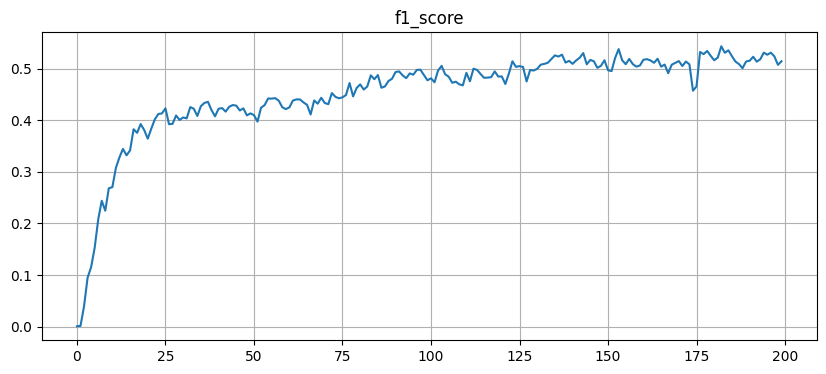

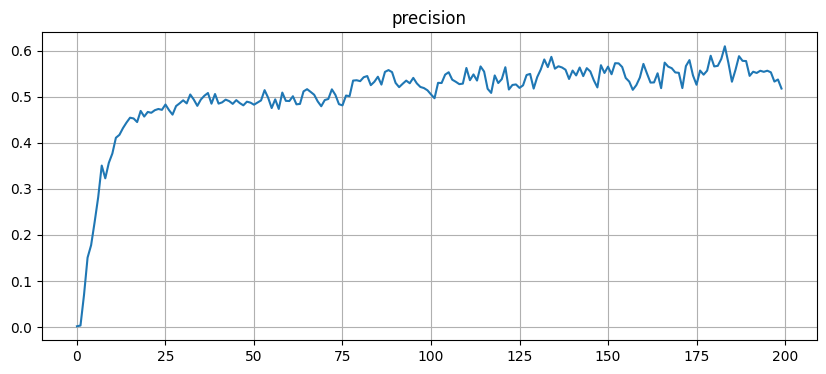

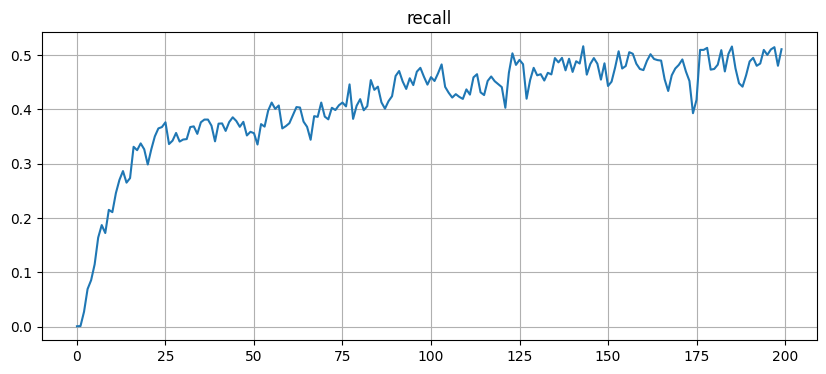

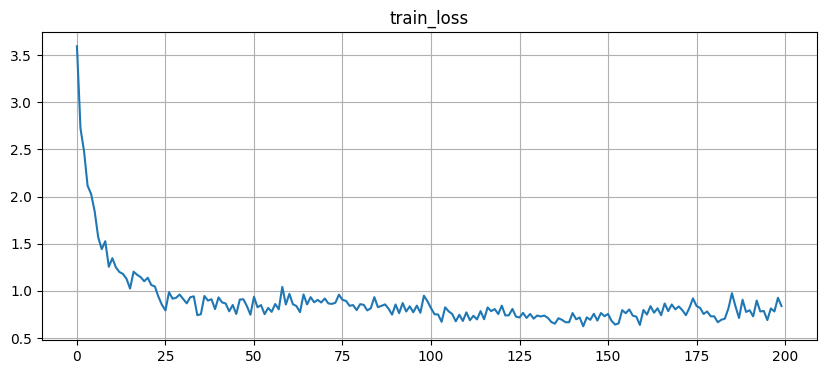

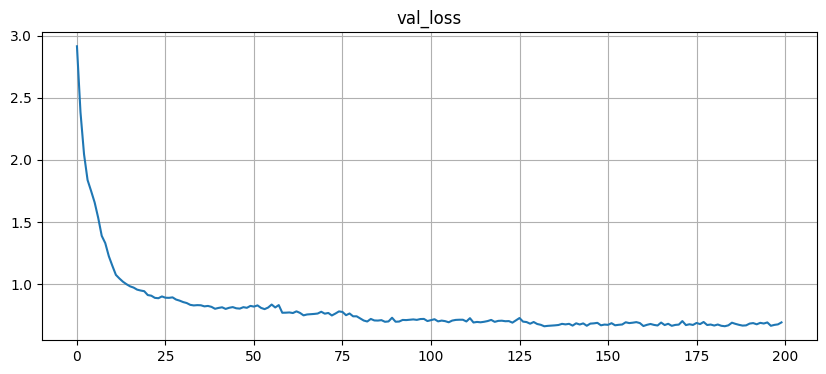

In [14]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()

In [15]:

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels_fromdata))

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test wmax: ', sanity_check (val_preds, val_labels_fromdata))


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Validation wmax:  (0.5809217577706324, 0.4533667921371811, 0.5092788348602302)


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Test wmax:  (0.5991146089522873, 0.464, 0.5229712322885358)


In [ ]:
#model.save_pretrained('./rut5small_7332-7420')
#tokenizer.save_pretrained('./rut5small_7332-7420')
#checkpoint = { 
#    'epoch': 250,
#    'model': model.state_dict(),
#    'optimizer': optimizer.state_dict()}
#torch.save (checkpoint, './rut5small_7332-7420/checkpoint.pth')

In [ ]:
model.load_state_dict (prev_model)
optimizer.load_state_dict (prev_optimizer)

In [ ]:

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels_fromdata))

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test wmax: ', sanity_check (val_preds, val_labels_fromdata))


In [ ]:
#model.save_pretrained('./rut5small_150ep_7168-7394')
#tokenizer.save_pretrained('./rut5small_150ep_7168-7394')
#checkpoint = { 
#    'epoch': 150,
#    'model': model.state_dict(),
#    'optimizer': optimizer.state_dict()}
#torch.save (checkpoint, './rut5small_150ep_7168-7394/checkpoint.pth')

In [ ]:
print s

https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/T5/Fine_tune_CodeT5_for_generating_docstrings_from_Ruby_code.ipynb#scrollTo=wvRHDkCIS91f

In [ ]:
# saved normal foldlearner

kf = KFold (n_splits = NUM_OF_SPLITS)

data = df ['text']
labels = df ['label']

inc_term_set = set ([''])
for iteration, (train_index, test_index) in enumerate (kf.split (data)):
    X_curr = data [test_index]
    y_curr = labels [test_index]

    train_data_lst = X_curr.tolist ()
    train_labels_lst = y_curr.tolist ()
    parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)

    parallel_text_new = parallel_text#attach_dictionary_foundings (parallel_text, inc_term_set)

    train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')
    
    if ENABLE_LABEL_FIX:
        replaced = replace_padding (train_labels)
        train_labels = replaced

    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)

    for epoch in range (LOCAL_NUM_EPOCHS):
        model.train ()  # Устанавливаем модель в режим обучения
        total_loss = 0
        
        for batch in tqdm (train_loader):
            
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels_fromdata = batch ['labels'].to (model.device)

            #outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            loss = outputs.loss   ## DOUBLE CHECK if padding ...
            total_loss += loss.item ()

            loss.backward ()  # Обратное распространение
            optimizer.step ()  # Обновление параметров
            optimizer.zero_grad ()  # Обнуляем градиенты

            #scheduler.step ()  # Обновление learning rate
            torch.cuda.empty_cache ()
        

        avg_loss = total_loss / len (train_loader)

        metrics ['train_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, avg_loss))

        # Оценка на валидационной выборке
        model.eval ()  # Устанавливаем модель в режим оценки
        val_preds, val_labels = [], []
        total_val_loss = 0

        with torch.no_grad ():
            for batch in val_loader:
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length = SEQ_MAX_LENGTH)

                total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()

                val_preds.extend (outputs)
                val_labels.extend (labels_fromdata)
                torch.cuda.empty_cache ()

        avg_val_loss = total_val_loss / len (val_loader)

        prec, recl, f1sc = sanity_check (val_preds, val_labels)

        metrics ['val_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, avg_val_loss))
        metrics ['precision'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, prec))
        metrics ['recall'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, recl))
        metrics ['f1_score'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, f1sc))

        print (f'Epoch {(epoch + 1) + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs} / {NUM_OF_SPLITS * LOCAL_NUM_EPOCHS + num_passed_epochs}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
        
        torch.cuda.empty_cache ()


    for line in parallel_labels:
        inc_term_set |= set (line.split (SEP_TOKEN))
    inc_term_set -= set ([''])
    inc_term_set -= set ([LABEL_PREFIX_TOKEN])
    print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')

In [ ]:
kf = KFold (n_splits = NUM_OF_SPLITS)

data = df ['text']
labels = df ['label']

inc_term_set = set ([''])

for iteration, (train_index, test_index) in enumerate (kf.split (data)):
    X_curr = data [test_index]
    y_curr = labels [test_index]

    train_data_lst = X_curr.tolist ()
    train_labels_lst = y_curr.tolist ()
    parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)

    parallel_text_new = parallel_text#attach_dictionary_foundings (parallel_text, inc_term_set)

    train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')
    
    if ENABLE_LABEL_FIX:
        replaced = replace_padding (train_labels)
        train_labels = replaced

    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)


    prev_metric = 1000000 if view_at_loss else 0
    prev_model = model
    prev_optimizer = optimizer
    epoch = 0
    #for epoch in range (LOCAL_NUM_EPOCHS):
    while True:
        model.train ()  # Устанавливаем модель в режим обучения
        total_loss = 0
        
        for batch in tqdm (train_loader):
            
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels_fromdata = batch ['labels'].to (model.device)

            #outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            loss = outputs.loss   ## DOUBLE CHECK if padding ...
            total_loss += loss.item ()

            loss.backward ()  # Обратное распространение
            optimizer.step ()  # Обновление параметров
            optimizer.zero_grad ()  # Обнуляем градиенты

            #scheduler.step ()  # Обновление learning rate
            torch.cuda.empty_cache ()
        

        avg_loss = total_loss / len (train_loader)

        

        # Оценка на валидационной выборке
        model.eval ()  # Устанавливаем модель в режим оценки
        val_preds, val_labels = [], []
        total_val_loss = 0

        with torch.no_grad ():
            for batch in val_loader:
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length = SEQ_MAX_LENGTH)

                total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()

                val_preds.extend (outputs)
                val_labels.extend (labels_fromdata)
                torch.cuda.empty_cache ()

        avg_val_loss = total_val_loss / len (val_loader)

        prec, recl, f1sc = sanity_check (val_preds, val_labels)

        print (f'Epoch {(epoch + 1) + num_passed_epochs} / ---, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
        
        torch.cuda.empty_cache ()

        ### WHAT
        if (view_at_loss and prev_metric < avg_val_loss) or (not view_at_loss and prev_metric > f1sc):
        #if prev_f1_score > f1sc:
            model = prev_model
            optimizer = prev_optimizer
            num_passed_epochs += epoch
            break
        epoch += 1
        #prev_f1_score = f1sc
        prev_metric = avg_val_loss if view_at_loss else f1sc
        prev_model = model
        prev_optimizer = optimizer

        metrics ['train_loss'].append ((epoch + num_passed_epochs, avg_loss))
        metrics ['val_loss'].append ((epoch + num_passed_epochs, avg_val_loss))
        metrics ['precision'].append ((epoch + num_passed_epochs, prec))
        metrics ['recall'].append ((epoch + num_passed_epochs, recl))
        metrics ['f1_score'].append ((epoch + num_passed_epochs, f1sc))
        

    for line in parallel_labels:
        inc_term_set |= set (line.split (SEP_TOKEN))
    inc_term_set -= set ([''])
    inc_term_set -= set ([LABEL_PREFIX_TOKEN])
    print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')

In [ ]:
print (metrics)

In [ ]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()

In [ ]:


model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation: ', sanity_check (val_preds, val_labels_fromdata))


val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test: ', sanity_check (val_preds, val_labels_fromdata))


In [ ]:

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels_fromdata))

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test wmax: ', sanity_check (val_preds, val_labels_fromdata))


In [ ]:
#model.save_pretrained ('./rut5base_fulltrain_novalid_dictionary_postfix')
#tokenizer.save_pretrained ('./rut5base_fulltrain_novalid_dictionary_postfix')

In [ ]:
print (val_parallel_text [6])
predicted_set = get_set (val_preds [6], ground_truth = False)
predicted_set

In [ ]:
kf = KFold (n_splits = NUM_OF_SPLITS)

data = df ['text']
labels = df ['label']

inc_term_set = set ([''])

#num_passed_epochs = 0


test_indices = list (kf.split (data))
test_indices.reverse ()


for iteration, (train_index, test_index) in enumerate (test_indices):
    X_curr = data [test_index]
    y_curr = labels [test_index]

    train_data_lst = X_curr.tolist ()
    train_labels_lst = y_curr.tolist ()
    parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)

    parallel_text_new = parallel_text#attach_dictionary_foundings (parallel_text, inc_term_set)

    train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')
    
    if ENABLE_LABEL_FIX:
        replaced = replace_padding (train_labels)
        train_labels = replaced

    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)


    #prev_f1_score = 0
    prev_metric = 1000000 if view_at_loss else 0
    prev_model = model
    prev_optimizer = optimizer
    epoch = 0
    #for epoch in range (LOCAL_NUM_EPOCHS):
    while True:
        model.train ()  # Устанавливаем модель в режим обучения
        total_loss = 0
        
        for batch in tqdm (train_loader):
            
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels_fromdata = batch ['labels'].to (model.device)

            #outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            loss = outputs.loss   ## DOUBLE CHECK if padding ...
            total_loss += loss.item ()

            loss.backward ()  # Обратное распространение
            optimizer.step ()  # Обновление параметров
            optimizer.zero_grad ()  # Обнуляем градиенты

            #scheduler.step ()  # Обновление learning rate
            torch.cuda.empty_cache ()
        

        avg_loss = total_loss / len (train_loader)

        

        # Оценка на валидационной выборке
        model.eval ()  # Устанавливаем модель в режим оценки
        val_preds, val_labels = [], []
        total_val_loss = 0

        with torch.no_grad ():
            for batch in val_loader:
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length = SEQ_MAX_LENGTH)

                total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()

                val_preds.extend (outputs)
                val_labels.extend (labels_fromdata)
                torch.cuda.empty_cache ()

        avg_val_loss = total_val_loss / len (val_loader)

        prec, recl, f1sc = sanity_check (val_preds, val_labels)

        print (f'Epoch {(epoch + 1) + num_passed_epochs} / ---, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
        
        torch.cuda.empty_cache ()

        ### WHAT
        if (view_at_loss and prev_metric < avg_val_loss) or (not view_at_loss and prev_metric > f1sc):
        #if prev_f1_score > f1sc:
            model = prev_model
            optimizer = prev_optimizer
            num_passed_epochs += epoch
            break
        epoch += 1
        #prev_f1_score = f1sc
        prev_metric = avg_val_loss if view_at_loss else f1sc
        prev_model = model
        prev_optimizer = optimizer

        metrics ['train_loss'].append ((epoch + num_passed_epochs, avg_loss))
        metrics ['val_loss'].append ((epoch + num_passed_epochs, avg_val_loss))
        metrics ['precision'].append ((epoch + num_passed_epochs, prec))
        metrics ['recall'].append ((epoch + num_passed_epochs, recl))
        metrics ['f1_score'].append ((epoch + num_passed_epochs, f1sc))
        

    for line in parallel_labels:
        inc_term_set |= set (line.split (SEP_TOKEN))
    inc_term_set -= set ([''])
    inc_term_set -= set ([LABEL_PREFIX_TOKEN])
    print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')

In [ ]:
print (metrics)

In [ ]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()

In [ ]:


model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation: ', sanity_check (val_preds, val_labels_fromdata))


val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test: ', sanity_check (val_preds, val_labels_fromdata))


In [ ]:

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels_fromdata))

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test wmax: ', sanity_check (val_preds, val_labels_fromdata))


In [ ]:
model.eval ()
total_val_loss = 0
with torch.no_grad ():
    for batch in val_loader:
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels_fromdata = batch ['labels'].to (model.device)

        outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()
        torch.cuda.empty_cache ()

avg_val_loss = total_val_loss / len (val_loader)
avg_val_loss

In [ ]:
kf = KFold (n_splits = NUM_OF_SPLITS)

data = df ['text']
labels = df ['label']

inc_term_set = set ([''])

#prev_f1_score = 0
prev_metric = 1.0496 if view_at_loss else 0.7126
for iteration, (train_index, test_index) in enumerate (kf.split (data)):
    X_curr = data [test_index]
    y_curr = labels [test_index]

    train_data_lst = X_curr.tolist ()
    train_labels_lst = y_curr.tolist ()
    parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)

    parallel_text_new = parallel_text#attach_dictionary_foundings (parallel_text, inc_term_set)

    train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')
    
    if ENABLE_LABEL_FIX:
        replaced = replace_padding (train_labels)
        train_labels = replaced

    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)
    
    prev_model = deepcopy (model.state_dict ())
    prev_optimizer = deepcopy (optimizer.state_dict ())
    epoch = 0
    #for epoch in range (LOCAL_NUM_EPOCHS):
    while True:

        model.train ()  # Устанавливаем модель в режим обучения
        total_loss = 0
        
        for batch in tqdm (train_loader):
            
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels_fromdata = batch ['labels'].to (model.device)

            #outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            loss = outputs.loss   ## DOUBLE CHECK if padding ...
            total_loss += loss.item ()

            loss.backward ()  # Обратное распространение
            optimizer.step ()  # Обновление параметров
            optimizer.zero_grad ()  # Обнуляем градиенты

            #scheduler.step ()  # Обновление learning rate
            torch.cuda.empty_cache ()
        

        avg_loss = total_loss / len (train_loader)

        

        # Оценка на валидационной выборке
        model.eval ()  # Устанавливаем модель в режим оценки
        val_preds, val_labels = [], []
        total_val_loss = 0

        with torch.no_grad ():
            for batch in val_loader:
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

                total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()

                val_preds.extend (outputs)
                val_labels.extend (labels_fromdata)
                torch.cuda.empty_cache ()

        avg_val_loss = total_val_loss / len (val_loader)

        prec, recl, f1sc = sanity_check (val_preds, val_labels)

        print (f'Epoch {(epoch + 1) + num_passed_epochs} / ---, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
        
        torch.cuda.empty_cache ()

        ### WHAT
        0

        metrics ['train_loss'].append ((epoch + num_passed_epochs, avg_loss))
        metrics ['val_loss'].append ((epoch + num_passed_epochs, avg_val_loss))
        metrics ['precision'].append ((epoch + num_passed_epochs, prec))
        metrics ['recall'].append ((epoch + num_passed_epochs, recl))
        metrics ['f1_score'].append ((epoch + num_passed_epochs, f1sc))
        

    for line in parallel_labels:
        inc_term_set |= set (line.split (SEP_TOKEN))
    inc_term_set -= set ([''])
    inc_term_set -= set ([LABEL_PREFIX_TOKEN])
    print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')

In [ ]:
print (metrics)

In [ ]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()

In [ ]:


model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation: ', sanity_check (val_preds, val_labels_fromdata))


val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test: ', sanity_check (val_preds, val_labels_fromdata))


In [ ]:

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels_fromdata))

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test wmax: ', sanity_check (val_preds, val_labels_fromdata))


In [ ]:
#model.save_pretrained('./rut5small_posttrain_folds_f1opt_avg-7531-7816-')
#tokenizer.save_pretrained('./rut5small_posttrain_folds_f1opt_avg-7531-7816-')

In [ ]:
print (tokenizer.decode (val_dataset [1] ['input_ids']))

batch = val_dataset [1:2]

input_ids = batch ['input_ids'].to (model.device)
attention_mask = batch ['attention_mask'].to (model.device)
labels = batch ['labels'].to (model.device)
out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)
out

In [ ]:
tokenizer.decode (out [0])

In [ ]:
out = model.generate (input_ids = input_ids, attention_mask = attention_mask)
out

In [ ]:
tokenizer.decode (out [0])

In [ ]:
get_set (out [0], ground_truth=False)

In [ ]:
idx = 5

print (tokenizer.decode (val_dataset [idx] ['input_ids']))

batch = val_dataset [idx: idx + 1]

input_ids = batch ['input_ids'].to (model.device)
attention_mask = batch ['attention_mask'].to (model.device)
labels = batch ['labels'].to (model.device)

In [ ]:
mout = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels)

In [ ]:
mout.logits.argmax (dim = -1)

In [ ]:
tokenizer.decode (mout.logits.argmax (dim = -1) [0])